# Pair trading  con todos los pares

       z-scores 
            Choice of beta calculacion: regresion / kalman filter
            Choice of averaging:
                  Using moving average window / exponential mean averaging / kalman filter  

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import numpy as np, os, copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from time import time
from read_data import load_ts, csv2npz
import arbitrage as ar
import cointegration as co
import utils


La clase cnf se utiliza para definir todos los parametros de configuracion del modelo

Se debe definir directorio donde se encuentran los datos

In [3]:
class cnf:
    pathdat='dat/' # directorio de los datos
    tipo='asset' # 'asset', 'return', 'log_return', 'log'
    mtd = 'kf' # 'kf' 'exp' 'on' 'off'
    Ntraining = 1000 # length of the training period
    beta_win=61   #21
    zscore_win=31 #11
    sigma_co=1.5 # thresold to buy
    sigma_ve=0.1 # thresold to sell
    nmax=-1 #-1 #  10 # number of companies to generate the pairs (-1 all, 10 for testing)
    nsel=100 # 100 # 10 # number of best pairs to select
    industry='oil'
    fname=f'tmp/all_pair_{mtd}_' # fig filename
    shorten=0

In [4]:
# load data
day,date,price,company = load_ts(sector=cnf.industry, pathdat=cnf.pathdat)

# select training period
assets_tr=price[:cnf.nmax,:cnf.Ntraining]


Hago las simulaciones de todos los pares con los assets seleccionados

In [5]:
t0 = time()
res = ar.all_pairs(assets_tr,company[:cnf.nmax],cnf)
print('Tiempo:  ',time()-t0)


/home/pulido/ass/finan2/arbitrage.py:77: RuntimeWarning: invalid value encountered in scalar divide
  zscore[it] = (spread[it] - spread_mean[it]) / spread_std[it]


Tiempo:   119.9708149433136


Selecciono los pares con los mejores resultados

In [6]:
# Select nsel best pairs
idx = np.argsort(res.capital[:,-1])[::-1][:cnf.nsel]
res.reorder(idx) # ordeno todo los resultados segun el capital

for cap,comp in zip(res.capital[:,-1],res.company):
    print(cap,comp)


1174.2270089911492 ['KGEI.O' 'CTRA.K']
709.223831271639 ['KGEI.O' 'CNX']
670.2863187869598 ['KGEI.O' 'GTE']
633.9430982330715 ['KGEI.O' 'OKE']
566.6002544851742 ['TPL' 'KGEI.O']
514.144721587066 ['DVN' 'KGEI.O']
506.20266511085975 ['OVV' 'KGEI.O']
487.4387550736968 ['OXY' 'KGEI.O']
474.16277056009204 ['COP' 'KGEI.O']
443.8147025782657 ['EQT' 'KGEI.O']
430.7231882458945 ['FANG.O' 'KGEI.O']
428.61191567604834 ['HES' 'KGEI.O']
424.98800818198004 ['USEG.O' 'KGEI.O']
418.08866475286663 ['WMB' 'SMC']
417.8126773391867 ['USEG.O' 'SM']
414.7008119325911 ['EOG' 'KGEI.O']
403.18385310572256 ['KGEI.O' 'RRC']
389.78969307360745 ['PNRG.O' 'KGEI.O']
383.2059172494446 ['KGEI.O' 'TRGP.K']
382.9481122064345 ['KGEI.O' 'OXY']
376.2410864294124 ['KGEI.O' 'EQT']
373.0924449866289 ['KGEI.O' 'EOG']
355.4327937708574 ['KGEI.O' 'MTDR.K']
346.23406185699 ['KGEI.O' 'CCJ']
339.870925915896 ['CVX' 'KGEI.O']
336.8148446294102 ['CLNE.O' 'GTE']
334.0858401904921 ['AR' 'KGEI.O']
331.501603294836 ['GPRK.K' 'GTE']
330.0

Calculo metricas de estacionaridad del spread para los pares seleccionados

In [7]:
metrics = co.stats(res.assets,'log')

Funciones usadas para graficacion. 

In [8]:
def vertical_bar(axs,compras,ccompras):
    ''' Plot the entrada y salida de posiciones '''
    start_indices, end_indices= utils.calc_startend(compras[:,None])
    start_cindices, end_cindices= utils.calc_startend(ccompras[:,None])

    indices=np.arange(compras.shape[0])
    for ax in axs:
        for start, end in zip(start_indices[0], end_indices[0]):
            ax.axvspan(indices[start], indices[end], alpha=0.3, color='green')
        for start, end in zip(start_cindices[0], end_cindices[0]):
            ax.axvspan(indices[start], indices[end], alpha=0.3, color='red')


In [9]:
def plot_capital_single(j,res0,fname):
    nt=res0.spread.shape[1]
    res = copy.deepcopy(res0) 
    res.reorder(j) # select the pair
    
    figfile=cnf.fname+f'capital{j}.png'
    
    fig, ax = plt.subplots(3,1,figsize=(7,7))
    ax[0].plot(res.zscore)
    ax[0].set_title('Z-score')
    

    for ivar in range(res.corto.shape[-1]):
        ax[1].plot(res.corto[:,ivar],label='corto '+res.company[ivar])
    ax[1].legend()

    for ivar in range(res.corto.shape[-1]):
        ax[2].plot(res.largo[:,ivar],label='largo '+res.company[ivar])
    ax[2].legend()

    vertical_bar(ax,res.compras,res.ccompras)

    plt.tight_layout()
    fig.savefig(figfile)
    plt.close()


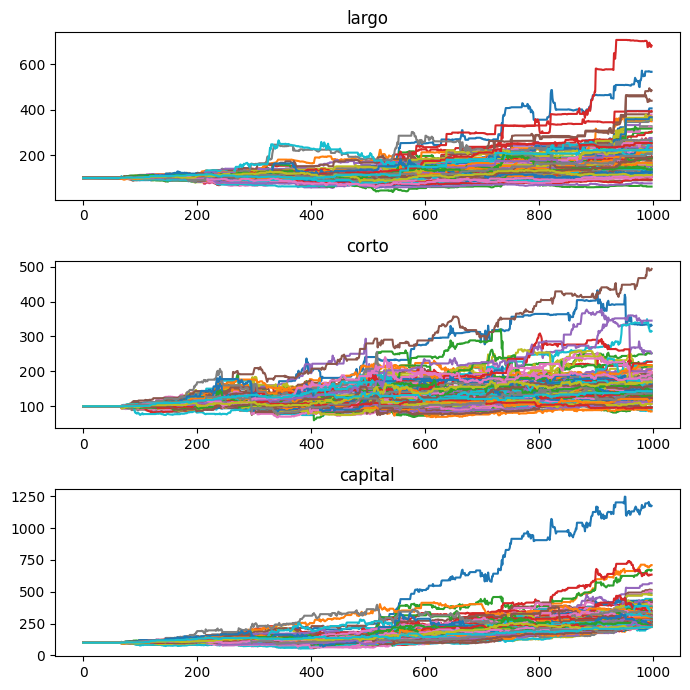

In [10]:
figfile=cnf.fname+'capital.png'
fig, ax = plt.subplots(3,1,figsize=(7,7))
ax[0].plot(res.largo.mean(-1).T)
ax[0].set(title='largo')
ax[1].plot(res.corto.mean(-1).T)
ax[1].set(title='corto')
ax[2].plot(res.capital.T)
ax[2].set(title='capital')
plt.tight_layout()
#fig.savefig(figfile)
plt.show()
plt.close()

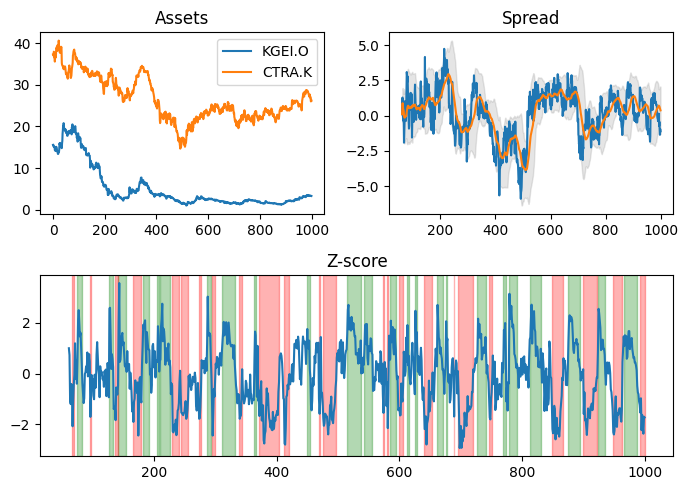

In [11]:
def plot_zscore(j,res0,fname):
    nt=res0.spread.shape[1]

    res = copy.deepcopy(res0) 
    res.reorder(j) # select the pair

    figfile=fname+f'zscore{j}.png'
    fig = plt.figure(figsize=(7, 5))

    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(res.assets[0],label=res.company[0])
    ax1.plot(res.assets[1],label=res.company[1])
    ax1.legend()
    ax1.set_title('Assets')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(range(nt),res.spread)
    ax2.plot(range(nt),res.spread_mean)
    ax2.fill_between(range(nt), res.spread_mean - 1.96* res.spread_std,
                     res.spread_mean +1.96* res.spread_std,color='gray', alpha=0.2)
    ax2.set_title('Spread')

    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(res.zscore)
    ax3.set_title('Z-score')

    vertical_bar([ax3],res.compras,res.ccompras)
    
    plt.tight_layout()
    #fig.savefig(figfile)
    plt.show()
    plt.close()


plot_zscore(0,res,cnf.fname)


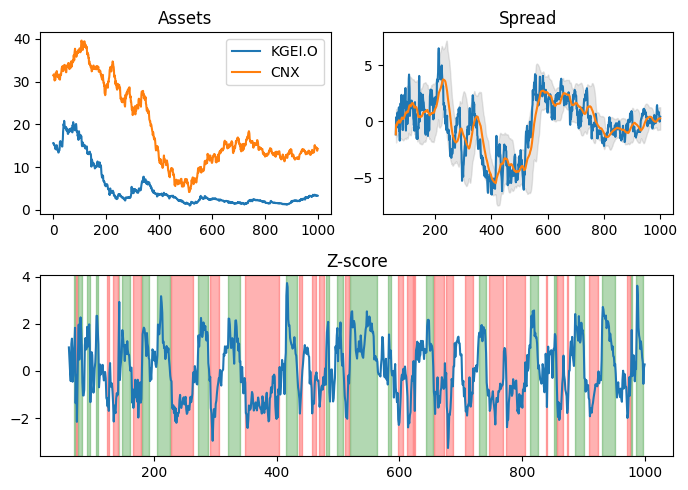

In [12]:
plot_zscore(1,res,cnf.fname)

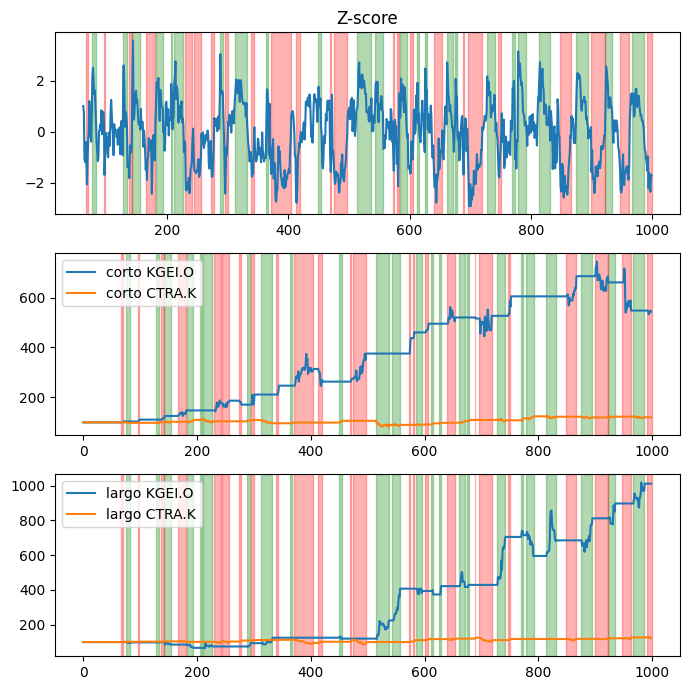

In [13]:
def plot_capital_single(j,res0,fname):
    nt=res0.spread.shape[1]
    res = copy.deepcopy(res0) 
    res.reorder(j) # select the pair
    
    figfile=cnf.fname+f'capital{j}.png'
    
    fig, ax = plt.subplots(3,1,figsize=(7,7))
    ax[0].plot(res.zscore)
    ax[0].set_title('Z-score')
    

    for ivar in range(res.corto.shape[-1]):
        ax[1].plot(res.corto[:,ivar],label='corto '+res.company[ivar])
    ax[1].legend()

    for ivar in range(res.corto.shape[-1]):
        ax[2].plot(res.largo[:,ivar],label='largo '+res.company[ivar])
    ax[2].legend()

    vertical_bar(ax,res.compras,res.ccompras)

    plt.tight_layout()
    #fig.savefig(figfile)
    plt.show()
    plt.close()
plot_capital_single(0,res,cnf.fname)

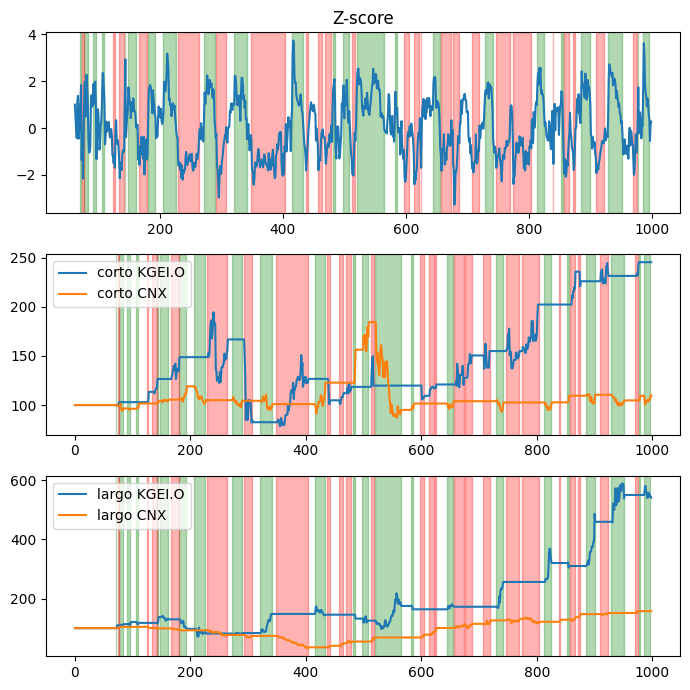

In [14]:
plot_capital_single(1,res,cnf.fname)


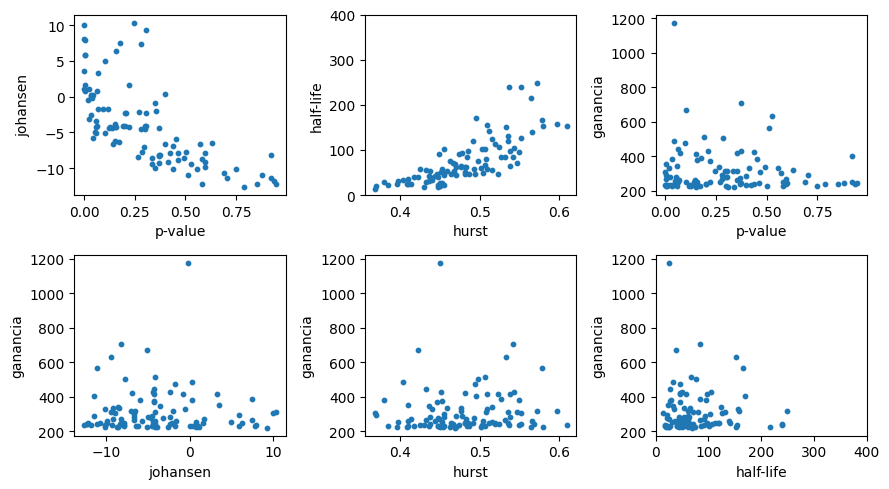

In [15]:
figfile=cnf.fname+f'scatters.png'
fig, ax = plt.subplots(2,3,figsize=(9,5))
ax[0,0].scatter(metrics.pvalue,metrics.johansen,s=10)
ax[0,0].set(xlabel='p-value',ylabel='johansen')
ax[0,1].scatter(metrics.hurst,metrics.half_life,s=10)
ax[0,1].set(xlabel='hurst',ylabel='half-life',ylim=[0,400])
ax[0,2].scatter(metrics.pvalue,res.capital[:,-1],s=10)
ax[0,2].set(xlabel='p-value',ylabel='ganancia')

ax[1,0].scatter(metrics.johansen,res.capital[:,-1],s=10)
ax[1,0].set(xlabel='johansen',ylabel='ganancia')
ax[1,1].scatter(metrics.hurst,res.capital[:,-1],s=10)
ax[1,1].set(xlabel='hurst',ylabel='ganancia')
ax[1,2].scatter(metrics.half_life,res.capital[:,-1],s=10)
ax[1,2].set(xlabel='half-life',ylabel='ganancia',xlim=[0,400])

plt.tight_layout()
#fig.savefig(figfile)
plt.show()
plt.close()
